### Data Cleaning

In [1]:
from timeit import default_timer as timer
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
%matplotlib inline
start_time = timer()
import time

In [2]:
orig_data = pd.read_csv("card transactions.csv")

In [3]:
orig_data.shape

(96753, 10)

In [4]:
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recnum             96753 non-null  int64  
 1   Cardnum            96753 non-null  int64  
 2   Date               96753 non-null  object 
 3   Merchnum           93378 non-null  object 
 4   Merch description  96753 non-null  object 
 5   Merch state        95558 non-null  object 
 6   Merch zip          92097 non-null  float64
 7   Transtype          96753 non-null  object 
 8   Amount             96753 non-null  float64
 9   Fraud              96753 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 7.4+ MB


In [5]:
data=orig_data.loc[(orig_data['Transtype']=='P') & (orig_data['Amount']<100000),] 
# second largest Amount 47900

In [6]:
data.shape

(96397, 10)

In [7]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [8]:
# Fill in Merchnum

merchdes_merchnum = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_merchnum :
        merchdes_merchnum[merchdes] = data.loc[index, 'Merchnum']

In [9]:
# Fill in by mapping to Merch description

data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/3759805366.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))


In [10]:
# Assign unknown for adjustments transactions

data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/2464082531.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/2464082531.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')


In [11]:
# Fill in Merch state

# If the record has a zip (known), use the state for that zip

zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']

In [12]:
# Fill in some state (if in range 00600 – 00799, 00900 – 00999: state = PR (Puerto Rico))

zip_state['00926'] = 'PR'
zip_state['00929'] = 'PR'
zip_state['00934'] = 'PR'
zip_state['00902'] = 'PR'
zip_state['00738'] = 'PR'
zip_state['90805'] = 'CA'
zip_state['76302'] = 'TX'
zip_state['00914'] = 'PR'
zip_state['95461'] = 'CA'
zip_state['00680'] = 'PR'
zip_state['00623'] = 'PR'
zip_state['00726'] = 'PR'
zip_state['00936'] = 'PR'
zip_state['12108'] = 'NY'
zip_state['00791'] = 'PR'
zip_state['00907'] = 'PR'
zip_state['00922'] = 'PR'
zip_state['00920'] = 'PR'
zip_state['00801'] = 'VI'
zip_state['31040'] = 'GA'
zip_state['41160'] = 'KY'
zip_state['00681'] = 'PR'

In [13]:
merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = data.loc[index, 'Merch state']

In [14]:
merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = data.loc[index, 'Merch state']

In [15]:
# Fill in by mapping to zip, merchnum and merch description

data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/1690524382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/1690524382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/1690524382.py:5: Sett

In [16]:
# Assign unknown for adjustments transactions

data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/1022395743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/1022395743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')


In [17]:
# Fill in Merch zip

merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

In [18]:
merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

In [19]:
# Fill in by mapping to Merchnum and merch description

data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/2084455614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/2084455614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))


In [20]:
# Assign unknown for adjustments transactions

data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/3333620027.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/3333620027.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')


In [21]:
# Fill the rest with unknown

data = data.fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recnum             96397 non-null  int64  
 1   Cardnum            96397 non-null  int64  
 2   Date               96397 non-null  object 
 3   Merchnum           96397 non-null  object 
 4   Merch description  96397 non-null  object 
 5   Merch state        96397 non-null  object 
 6   Merch zip          96397 non-null  object 
 7   Transtype          96397 non-null  object 
 8   Amount             96397 non-null  float64
 9   Fraud              96397 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 10.1+ MB


### Build variables

In [22]:
# one risk table variable: likelihood of fraud for that day of the week 
# Don’t use the OOT data to calculate the risk table

begin = time.time()

data['dow'] = pd.to_datetime(data['Date']).apply(lambda x: calendar.day_name[x.weekday()])
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Sunday
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday


In [23]:
# statistical smoothing

train_test = data[data.Date < '2006-11-01']
y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('dow')['Fraud'].mean()
num = train_test.groupby('dow').size()

c = 4; nmid = 20;
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))

data['dow_risk'] = data.dow.map(y_dow_smooth)

print(f'Total run time: {(time.time() - begin) / 60}min')

Total run time: 0.0074345986048380535min


In [24]:
y_dow = y_dow.reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow['dow'] = pd.Categorical(y_dow['dow'], categories = cats, ordered = True)
y_dow = y_dow.sort_values('dow')
y_dow = y_dow.set_index('dow')

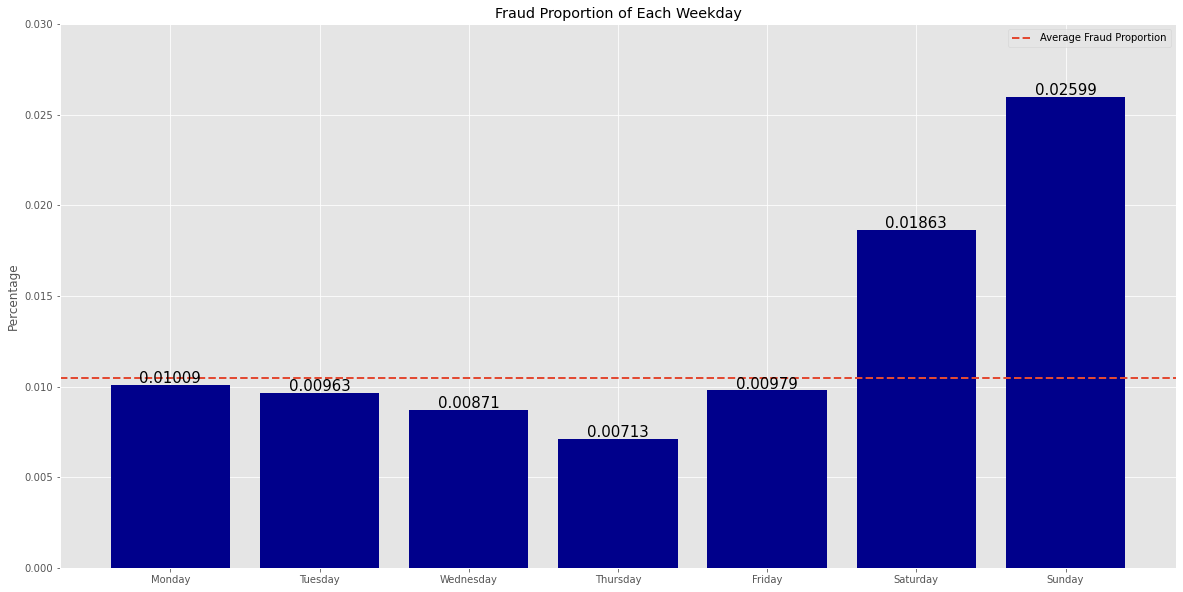

In [25]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20, 10))
plt.bar(data = y_dow, x = y_dow.index, height = 'Fraud', color = 'darkblue')
ax.axhline(y = y_avg, ls = '--', lw = 2, label = 'Average Fraud Proportion')
ax.set_ylim(top = 0.03)
 
for i in y_dow.index:
    ax.text(i, y_dow.loc[i, 'Fraud'] + 0.0001, round(y_dow.loc[i, 'Fraud'], 5), 
            horizontalalignment = 'center', fontsize = 15)
plt.title('Fraud Proportion of Each Weekday')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [26]:
# risk table variable: likelihood of fraud for that merchant state 

y_avg = train_test['Fraud'].mean()
y_state = train_test.groupby('Merch state')['Fraud'].mean()

In [27]:
# statistical smoothing

num = train_test.groupby('Merch state').size()
c = 4; nmid = 20;
y_state_smooth = y_avg + (y_state - y_avg)/(1 + np.exp(-(num - nmid)/c))

data['state_risk'] = data['Merch state'].map(y_state_smooth)

In [28]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,state_risk
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday,0.025994,0.003304
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday,0.025994,0.017282
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970


In [29]:
y_state_15 = y_state.sort_values(ascending = False)[:15]
y_state_15

Merch state
IN    0.084388
UT    0.044099
OR    0.024634
OH    0.024563
NY    0.023937
WA    0.020518
NM    0.018519
PA    0.018118
DC    0.017632
MD    0.017282
CA    0.014908
SD    0.014493
VA    0.013440
TX    0.012689
TN    0.007970
Name: Fraud, dtype: float64

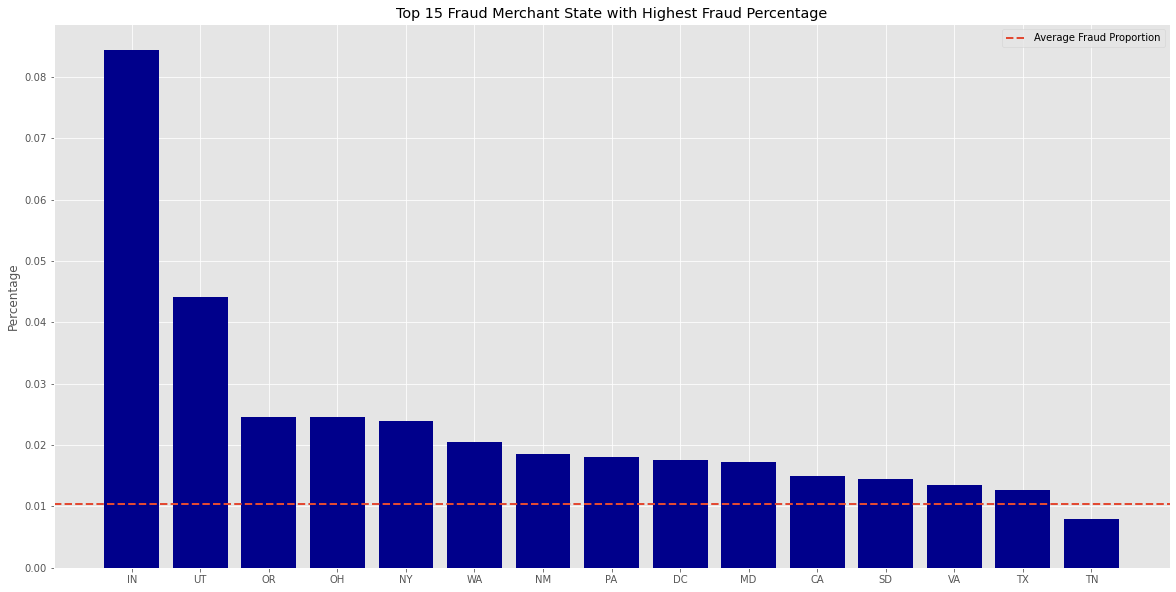

In [30]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20, 10))
plt.bar(data = y_state_15, x = y_state_15.index, height = y_state_15.values, color = 'darkblue')
ax.axhline(y = y_avg, ls = '--', lw = 2, label = 'Average Fraud Proportion')
    
plt.title('Top 15 Fraud Merchant State with Highest Fraud Percentage')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recnum             96397 non-null  int64  
 1   Cardnum            96397 non-null  int64  
 2   Date               96397 non-null  object 
 3   Merchnum           96397 non-null  object 
 4   Merch description  96397 non-null  object 
 5   Merch state        96397 non-null  object 
 6   Merch zip          96397 non-null  object 
 7   Transtype          96397 non-null  object 
 8   Amount             96397 non-null  float64
 9   Fraud              96397 non-null  int64  
 10  dow                96397 non-null  object 
 11  dow_risk           96397 non-null  float64
 12  state_risk         96397 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 12.3+ MB


In [32]:
data['Cardnum']=data['Cardnum'].astype('str')
data['Merchnum']=data['Merchnum'].astype('str')
data['Merch zip']=data['Merch zip'].astype('str')
data['Merch state']=data['Merch state'].astype('str')
data['dow']=data['dow'].astype('str')

In [33]:
data['Merch zip3']=data['Merch zip'].astype(str).str[:3]
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,state_risk,Merch zip3
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970,381
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday,0.025994,0.003304,180
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday,0.025994,0.017282,207
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970,381
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970,381


In [34]:
data['merch_desc_short'] = data['Merch description'].copy().str.replace(r' [0-9][0-9]/[0-9][0-9]/[0-9][0-9] AB#', '')
data['merch_desc_short'] = data['merch_desc_short'].str.replace(r' #[0-9][0-9][0-9]', '')
data['merch_desc_short'] = data['merch_desc_short'].str.replace(r'AMAZON.COM.*', 'AMAZON.COM')
data['merch_desc_short'] = data['merch_desc_short'].str.replace(r'BEST BUY.*', 'BEST BUY')
data['merch_desc_short'] = data['merch_desc_short'].str.replace(r' [0-9]*', '')
data['merch_desc_short'] = data['merch_desc_short'].str.replace(r'#[0-9]*', '')

data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month.astype(str)
data.head()

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/675450393.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['merch_desc_short'] = data['Merch description'].copy().str.replace(r' [0-9][0-9]/[0-9][0-9]/[0-9][0-9] AB#', '')
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/675450393.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['merch_desc_short'] = data['merch_desc_short'].str.replace(r' #[0-9][0-9][0-9]', '')
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/675450393.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['merch_desc_short'] = data['merch_desc_short'].str.replace(r'AMAZON.COM.*', 'AMAZON.COM')
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/675450393.py:4: FutureWarning: The default value of regex will change from True to False in a future 

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,state_risk,Merch zip3,merch_desc_short,Month
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970,381,FEDEXSHP,1
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday,0.025994,0.003304,180,SERVICEMERCHANDISE,1
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday,0.025994,0.017282,207,OFFICEDEPOT,1
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970,381,FEDEXSHP,1
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970,381,FEDEXSHP,1


In [35]:
# make new entities for variables

data['card_merch'] = data['Cardnum'] + data.Merchnum
data['card_zip'] = data['Cardnum'] + data['Merch zip']
data['card_state'] = data['Cardnum'] + data['Merch state']
data['merch_zip'] = data.Merchnum + data['Merch zip']
data['merch_state'] = data.Merchnum + data['Merch state']

data['card_dow'] = data['Cardnum'] + data.dow
data['merch_dow'] = data.Merchnum + data.dow

data['card_merchdesc']=data['Cardnum']+data['Merch description']
data['card_zip3']=data['Cardnum']+data['Merch zip3']

data['card_merch_month'] = data['Cardnum'] + data['Merchnum'] + data['Month']
data['card_state_month'] = data['Cardnum'] + data['Merch state'] + data['Month']
data['card_zip_month'] = data['Cardnum'] + data['Merch zip'].astype('str') + data['Month']
data['card_merchdesc_short'] = data['Cardnum'] + data['merch_desc_short']

In [36]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merch_zip,merch_state,card_dow,merch_dow,card_merchdesc,card_zip3,card_merch_month,card_state_month,card_zip_month,card_merchdesc_short
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,550900629625438118.0,5509006296254TN,5142190439Sunday,5509006296254Sunday,5142190439FEDEX SHP 12/23/09 AB#,5142190439381,514219043955090062962541,5142190439TN1,514219043938118.01,5142190439FEDEXSHP
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,610030263331803.0,61003026333MA,5142183973Sunday,61003026333Sunday,5142183973SERVICE MERCHANDISE #81,5142183973180,5142183973610030263331,5142183973MA1,51421839731803.01,5142183973SERVICEMERCHANDISE
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,450308299360020706.0,4503082993600MD,5142131721Sunday,4503082993600Sunday,5142131721OFFICE DEPOT #191,5142131721207,514213172145030829936001,5142131721MD1,514213172120706.01,5142131721OFFICEDEPOT
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,550900629625438118.0,5509006296254TN,5142148452Sunday,5509006296254Sunday,5142148452FEDEX SHP 12/28/09 AB#,5142148452381,514214845255090062962541,5142148452TN1,514214845238118.01,5142148452FEDEXSHP
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,550900629625438118.0,5509006296254TN,5142190439Sunday,5509006296254Sunday,5142190439FEDEX SHP 12/23/09 AB#,5142190439381,514219043955090062962541,5142190439TN1,514219043938118.01,5142190439FEDEXSHP


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Recnum                96397 non-null  int64         
 1   Cardnum               96397 non-null  object        
 2   Date                  96397 non-null  datetime64[ns]
 3   Merchnum              96397 non-null  object        
 4   Merch description     96397 non-null  object        
 5   Merch state           96397 non-null  object        
 6   Merch zip             96397 non-null  object        
 7   Transtype             96397 non-null  object        
 8   Amount                96397 non-null  float64       
 9   Fraud                 96397 non-null  int64         
 10  dow                   96397 non-null  object        
 11  dow_risk              96397 non-null  float64       
 12  state_risk            96397 non-null  float64       
 13  Merch zip3      

In [38]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'dow',
       'dow_risk', 'state_risk', 'Merch zip3', 'merch_desc_short', 'Month',
       'card_merch', 'card_zip', 'card_state', 'merch_zip', 'merch_state',
       'card_dow', 'merch_dow', 'card_merchdesc', 'card_zip3',
       'card_merch_month', 'card_state_month', 'card_zip_month',
       'card_merchdesc_short'],
      dtype='object')

In [39]:
entities = list(data.iloc[:, np.r_[1, 3, 16:29]].columns)
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'card_dow',
 'merch_dow',
 'card_merchdesc',
 'card_zip3',
 'card_merch_month',
 'card_state_month',
 'card_zip_month',
 'card_merchdesc_short']

In [40]:
# make variables

df1 = data.copy()
vars = data.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum
vars.shape

(96397, 29)

In [41]:
begin = time.time()
for entity in entities:    
    st = time.time() 
    
    ## Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last() # most recent
    mapper = (pd.to_datetime(temp1.Date) - pd.to_datetime(temp1.check_date)).dt.days
    vars[entity + '_day_since'] = vars.Recnum.map(mapper)
    vars[entity + '_day_since'].fillna(365, inplace = True) # if never seen before, default value is 365
    
    print('\n' + entity + '_day_since ---> Done') 
    print(f'Run time for entity {entity} ----------------- {time.time() - st}s')

print(f'Total run time: {(time.time() - begin) / 60}min')


Cardnum_day_since ---> Done
Run time for entity Cardnum ----------------- 2.882573127746582s

Merchnum_day_since ---> Done
Run time for entity Merchnum ----------------- 27.455667972564697s

card_merch_day_since ---> Done
Run time for entity card_merch ----------------- 1.0243782997131348s

card_zip_day_since ---> Done
Run time for entity card_zip ----------------- 0.5255708694458008s

card_state_day_since ---> Done
Run time for entity card_state ----------------- 0.5633161067962646s

merch_zip_day_since ---> Done
Run time for entity merch_zip ----------------- 22.100205183029175s

merch_state_day_since ---> Done
Run time for entity merch_state ----------------- 22.762070178985596s

card_dow_day_since ---> Done
Run time for entity card_dow ----------------- 0.8454639911651611s

merch_dow_day_since ---> Done
Run time for entity merch_dow ----------------- 2.6351709365844727s

card_merchdesc_day_since ---> Done
Run time for entity card_merchdesc ----------------- 0.23316287994384766s

c

In [42]:
vars.shape

(96397, 44)

In [43]:
for entity in entities:    
    
    ## Frequency variables:   
    for time in [0,1,3,7,14,30,90]:    
        df_l = df1[['Recnum', 'Date', entity]]
        df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
        temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
        
        temp2 = temp[(pd.to_datetime(temp.check_date) >= (pd.to_datetime(temp.Date) - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        vars[col_name] = vars.Recnum.map(mapper2) 
        
        print(col_name + ' ---> Done')       

Cardnum_count_0 ---> Done
Cardnum_count_1 ---> Done
Cardnum_count_3 ---> Done
Cardnum_count_7 ---> Done
Cardnum_count_14 ---> Done
Cardnum_count_30 ---> Done
Merchnum_count_0 ---> Done
Merchnum_count_1 ---> Done
Merchnum_count_3 ---> Done
Merchnum_count_7 ---> Done
Merchnum_count_14 ---> Done
Merchnum_count_30 ---> Done
card_merch_count_0 ---> Done
card_merch_count_1 ---> Done
card_merch_count_3 ---> Done
card_merch_count_7 ---> Done
card_merch_count_14 ---> Done
card_merch_count_30 ---> Done
card_zip_count_0 ---> Done
card_zip_count_1 ---> Done
card_zip_count_3 ---> Done
card_zip_count_7 ---> Done
card_zip_count_14 ---> Done
card_zip_count_30 ---> Done
card_state_count_0 ---> Done
card_state_count_1 ---> Done
card_state_count_3 ---> Done
card_state_count_7 ---> Done
card_state_count_14 ---> Done
card_state_count_30 ---> Done
merch_zip_count_0 ---> Done
merch_zip_count_1 ---> Done
merch_zip_count_3 ---> Done
merch_zip_count_7 ---> Done
merch_zip_count_14 ---> Done
merch_zip_count_30 --

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)


card_zip_month_count_7 ---> Done
card_zip_month_count_14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)


card_zip_month_count_30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)


card_merchdesc_short_count_0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)


card_merchdesc_short_count_1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)


card_merchdesc_short_count_3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)


card_merchdesc_short_count_7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)


card_merchdesc_short_count_14 ---> Done
card_merchdesc_short_count_30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/425119321.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)


In [45]:
for entity in entities:    
    
    ## Amount variables:   
    for time in [0,1,3,7,14,30,90]:
        df_l = df1[['Recnum', 'Date', entity]]
        df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
        temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity) 
        
        temp2 = temp[(pd.to_datetime(temp.check_date) >= (pd.to_datetime(temp.Date) - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]           
               
        vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        vars[entity + '_std_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].std())
        vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        vars[entity + '_actual/avg_' + str(time)] = vars['Amount'] / vars[entity + '_avg_' + str(time)]
        vars[entity + '_actual/max_' + str(time)] = vars['Amount'] / vars[entity + '_max_' + str(time)]
        vars[entity + '_actual/med_' + str(time)] = vars['Amount'] / vars[entity + '_med_' + str(time)]
        vars[entity + '_actual/toal_' + str(time)] = vars['Amount'] / vars[entity + '_total_' + str(time)] 
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Cardnum amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Cardnum amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Cardnum amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Cardnum amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Cardnum amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Cardnum amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Merchnum amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Merchnum amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Merchnum amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Merchnum amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Merchnum amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

Merchnum amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merch amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merch amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merch amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merch amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merch amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merch amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_state amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_state amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_state amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_state amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_state amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_state amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_zip amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_zip amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_zip amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_zip amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_zip amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_zip amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_state amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_state amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_state amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_state amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_state amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_state amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_dow amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_dow amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_dow amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_dow amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_dow amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_dow amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_dow amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_dow amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_dow amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_dow amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_dow amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

merch_dow amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merchdesc amount variables over past 0 ---> Done
card_merchdesc amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: Per

card_merchdesc amount variables over past 3 ---> Done
card_merchdesc amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merchdesc amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merchdesc amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip3 amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip3 amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip3 amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip3 amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip3 amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip3 amount variables over past 30 ---> Done
card_merch_month amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merch_month amount variables over past 1 ---> Done
card_merch_month amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merch_month amount variables over past 7 ---> Done
card_merch_month amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:16: P

card_merch_month amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:16: P

card_state_month amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:16: P

card_state_month amount variables over past 1 ---> Done
card_state_month amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_actual/avg_' + str(time)] = vars['Amount'] / vars[entity + '_avg_' + str(time)]
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:17: Pe

card_state_month amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_actual/avg_' + str(time)] = vars['Amount'] / vars[entity + '_avg_' + str(time)]
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:17: Pe

card_state_month amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_actual/avg_' + str(time)] = vars['Amount'] / vars[entity + '_avg_' + str(time)]
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:17: Pe

card_state_month amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:16: P

card_zip_month amount variables over past 0 ---> Done
card_zip_month amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_zip_month amount variables over past 3 ---> Done
card_zip_month amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: Per

card_zip_month amount variables over past 14 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:15: Per

card_zip_month amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merchdesc_short amount variables over past 0 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merchdesc_short amount variables over past 1 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merchdesc_short amount variables over past 3 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merchdesc_short amount variables over past 7 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

card_merchdesc_short amount variables over past 14 ---> Done
card_merchdesc_short amount variables over past 30 ---> Done


/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/302871207.py:14: Perfo

In [47]:
# velocity change variables

for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '90']:
            vars[ent + '_count_' + d + '_by_' + dd] = \
            vars[ent + '_count_' + d]/(vars[ent + '_count_' + dd]/float(dd))  
            
            # longer time window/number of days, average number per day
            # shorter time window/0 or 1, so no need to divide by the number of days
            
            vars[ent + '_total_' + d + '_by_' + dd] = \
            vars[ent + '_total_' + d]/(vars[ent + '_total_' + dd]/float(dd))

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/787002551.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[ent + '_count_' + d + '_by_' + dd] = \
/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/787002551.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[ent + '_total_' + d + '_by_' + dd] = \


In [51]:
vars.groupby(['Merchnum', 'Amount'])['Merchnum'].count()

Merchnum  Amount  
0         16.50       1
          19.39       2
          19.44       1
          25.00       1
          31.31       1
                     ..
unknown   10967.44    1
          25805.35    1
          27218.00    1
          28392.84    1
          47900.00    1
Name: Merchnum, Length: 74068, dtype: int64

In [52]:
# vars['Merchant with same amount' + '_count'] = []
list_ = []
table = vars.groupby(['Merchnum', 'Amount'])['Merchnum'].count()
for i in vars.index:
    merchnum = vars['Merchnum'][i]
    amount = vars['Amount'][i]
    list_.append(table[(table.index.get_level_values(0) == merchnum) & \
                       (table.index.get_level_values(1) == amount)].values[0])
list_

[759,
 1,
 1,
 759,
 759,
 232,
 759,
 1,
 1,
 759,
 759,
 759,
 81,
 1,
 1,
 140,
 174,
 232,
 232,
 1,
 759,
 759,
 232,
 3,
 232,
 759,
 1,
 759,
 2,
 174,
 759,
 1,
 2,
 759,
 759,
 140,
 140,
 1,
 759,
 759,
 1,
 759,
 759,
 174,
 1,
 759,
 759,
 759,
 1,
 1,
 1,
 42,
 1,
 5,
 6,
 54,
 1,
 180,
 42,
 42,
 42,
 42,
 1,
 1,
 42,
 42,
 54,
 9,
 1,
 54,
 10,
 1,
 42,
 3,
 1,
 1,
 3,
 42,
 1,
 54,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 33,
 1,
 1,
 1,
 3,
 1,
 33,
 33,
 759,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 232,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 33,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 33,
 33,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 759,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 759,
 1,
 2,
 180,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 759,
 33,
 1,
 3,
 1,
 16,
 1,
 1,
 3,
 1,
 1,
 759,
 1,
 1,
 759,
 1,
 2,
 4,
 1,
 1,
 1,
 33,
 6,
 1,
 1,
 33,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 759,
 1,
 1,
 1,
 1,
 759,
 1,
 

In [53]:
vars['Merchant_with_same_amount_count'] = list_

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/3743558050.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['Merchant_with_same_amount_count'] = list_


### Benford's Law Variables

In [56]:
data_forBen = data[data['Merch description'].str.match(r"[Ff][Ee][Dd][Ee][Xx]")==False].copy()
data_forBen['Amount'] = data_forBen['Amount'].astype(str)

In [57]:
def n_low(df):
    return ((df['Amount'].str.extract(r"([1-9])")== '1') | (df['Amount'].str.extract(r"([1-9])")== '2')).sum()

In [58]:
cardnums = data_forBen.groupby('Cardnum').apply(n_low)
cardnums['n'] = data_forBen.groupby('Cardnum')['Amount'].count()
cardnums['n_low'] = data_forBen.groupby('Cardnum').apply(n_low)
cardnums = cardnums[['n', 'n_low']]
cardnums['n_high'] = cardnums['n'] - cardnums['n_low'] 

In [59]:
cardnums['n_low'] = cardnums['n_low'].replace(0, 1)
cardnums['n_high'] = cardnums['n_high'].replace(0, 1)

In [60]:
cardnums['R'] = 1.096 * cardnums['n_low'] / cardnums['n_high']
cardnums['1/R'] = 1 / cardnums['R']
cardnums['U'] = cardnums[['R', '1/R']].max(axis = 1)

In [61]:
cardnums['t'] = (cardnums['n'] - 15)/3
cardnums['U*'] = 1 + ((cardnums['U'] - 1)/(1+np.exp(-cardnums['t'])))

In [62]:
cardnums['U*']

Cardnum
5142110002    1.000894
5142110081    1.066041
5142110313    1.021440
5142110402    1.298955
5142110434    1.000894
                ...   
5142310397    1.000894
5142310525    1.043299
5142310598    1.015441
5142310768    1.002393
5142847398    3.193331
Name: U*, Length: 1640, dtype: float64

In [63]:
card_list = []
for i in vars.index:
    if vars['Cardnum'][i] not in cardnums.index:
        card_list.append(np.NaN)
    else:
        card_list.append(cardnums.loc[cardnums.index == vars['Cardnum'][i], 'U*'].values[0]) 
card_list

[2.1780080056509377,
 1.6048571428571432,
 2.3681428571428573,
 1.0441050811481836,
 2.1780080056509377,
 1.4613333282989147,
 1.437043795620358,
 1.5206812622895414,
 1.2310276908817055,
 2.1780080056509377,
 1.0865022204110089,
 2.1780080056509377,
 1.3308571428554525,
 1.0538461538461539,
 1.2485480705259122,
 1.0441050811481836,
 1.0441050811481836,
 1.2672107590295854,
 1.4124087591240875,
 1.2014582307263078,
 2.1780080056509377,
 2.1780080056509377,
 2.1780080056509377,
 1.2165424207391666,
 1.0518045417680453,
 1.25717646955578,
 1.0761744338330663,
 2.1780080056509377,
 1.3104347826085854,
 1.0441050811481836,
 1.3379786808225793,
 3.1933310798573347,
 1.0862009037185372,
 2.1780080056509377,
 1.4042500000000002,
 1.274418604649761,
 1.0441050811481836,
 1.0676551724137933,
 1.01768666422391,
 2.1780080056509377,
 1.5206812622895414,
 1.0441050811481836,
 1.7953849776255981,
 1.0441050811481836,
 1.1730969620590144,
 1.0527792762009525,
 1.4060757031534603,
 2.1780080056509377

In [64]:
vars['Benford’s_Law_cardnum_U*'] = card_list

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/113905097.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['Benford’s_Law_cardnum_U*'] = card_list


In [65]:
cardnums.sort_values('U*', ascending = False)[0:40].to_csv('Top 40 Card num.csv')

In [66]:
cardnums.sort_values('U*', ascending = False)[0:40]

,n,n_low,n_high,R,1/R,U,t,U*
Cardnum,,,,,,,,
5142253356,66,61,5,13.371200,0.074788,13.371200,17.000000,13.371199
5142299705,28,25,3,9.133333,0.109489,9.133333,4.333333,9.027976
5142197563,149,15,134,0.122687,8.150852,8.150852,44.666667,8.150852
5142194617,38,5,33,0.166061,6.021898,6.021898,7.666667,6.019548
5142288241,14,1,13,0.084308,11.861314,11.861314,-0.333333,5.533836
5142239140,19,16,3,5.845333,0.171077,5.845333,1.333333,4.834555
5142144931,36,6,30,0.219200,4.562044,4.562044,7.000000,4.558799
5142192606,15,13,2,7.124000,0.140371,7.124000,0.000000,4.062000
5142204384,253,199,54,4.038963,0.247588,4.038963,79.333333,4.038963


In [67]:
merchnums = data_forBen.groupby('Merchnum').apply(n_low)
merchnums['n'] = data_forBen.groupby('Merchnum')['Amount'].count()
merchnums['n_low'] = data_forBen.groupby('Merchnum').apply(n_low)
merchnums = merchnums[['n', 'n_low']]
merchnums['n_high'] = merchnums['n'] - merchnums['n_low']

In [68]:
merchnums['n_low'] = merchnums['n_low'].replace(0, 1)
merchnums['n_high'] = merchnums['n_high'].replace(0, 1)

In [69]:
merchnums['R'] = 1.096 * merchnums['n_low'] / merchnums['n_high']
merchnums['1/R'] = 1 / merchnums['R']
merchnums['U'] = merchnums[['R', '1/R']].max(axis = 1)

In [70]:
merchnums['t'] = (merchnums['n'] - 15)/3
merchnums['U*'] = 1 + ((merchnums['U'] - 1)/(1+np.exp(-merchnums['t'])))

In [71]:
merchnums['U*']

Merchnum
0                1.177185
003100006NOT6    1.000894
004740006ABC6    1.000894
005590006PNB6    1.000894
014430619  14    1.000894
                   ...   
DU49038320006    1.000894
JCPENNE9 CO      1.014835
PENNE9 CO #05    1.000894
PENNE9 CO #68    1.000894
unknown          1.044388
Name: U*, Length: 13084, dtype: float64

In [72]:
merch_list = []
for i in vars.index:
    if vars['Merchnum'][i] not in merchnums.index:
        merch_list.append(np.NaN)
    else:
        merch_list.append(merchnums.loc[merchnums.index == vars['Merchnum'][i], 'U*'].values[0]) 
merch_list

[nan,
 1.0008943320971264,
 1.0258183764515196,
 nan,
 nan,
 nan,
 nan,
 1.2704916740931018,
 1.009321616871705,
 nan,
 nan,
 nan,
 nan,
 1.2521867321867324,
 1.2521867321867324,
 nan,
 nan,
 nan,
 nan,
 1.0171829706981454,
 nan,
 nan,
 nan,
 1.080073616569967,
 nan,
 nan,
 1.2521867321867324,
 nan,
 1.2521867321867324,
 nan,
 nan,
 3.1933310798573347,
 1.623703685202189,
 nan,
 nan,
 nan,
 nan,
 1.1130463542838755,
 nan,
 nan,
 1.2873364217443353,
 nan,
 nan,
 nan,
 1.1807642763764594,
 nan,
 nan,
 nan,
 1.0334491315136476,
 1.0008943320971264,
 nan,
 12.056000000000001,
 1.041186183574625,
 1.4294403888399563,
 12.056000000000001,
 12.056000000000001,
 1.0008943320971264,
 165.14598540145985,
 12.056000000000001,
 12.056000000000001,
 12.056000000000001,
 12.056000000000001,
 12.056000000000001,
 1.4294403888399563,
 12.056000000000001,
 12.056000000000001,
 12.056000000000001,
 1.4294403888399563,
 12.056000000000001,
 12.056000000000001,
 1.4294403888399563,
 12.056000000000001,
 1

In [73]:
vars['Benford’s_Law_merchnum_U*'] = merch_list

/var/folders/gk/g0zl346x7djg2kwdf_95_1640000gn/T/ipykernel_88274/3483699202.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['Benford’s_Law_merchnum_U*'] = merch_list


In [74]:
merchnums.sort_values('U*', ascending = False)[0:40].to_csv('Top 40 Merchnum.csv')

In [75]:
merchnums.sort_values('U*', ascending = False)[0:40]

,n,n_low,n_high,R,1/R,U,t,U*
Merchnum,,,,,,,,
991808369338,181,1,181,0.006055,165.145985,165.145985,55.333333,165.145985
8078200641472,60,59,1,64.664000,0.015465,64.664000,15.000000,64.663981
308904389335,53,1,53,0.020679,48.357664,48.357664,12.666667,48.357515
3523000628102,34,34,1,37.264000,0.026836,37.264000,6.333333,37.199706
808998385332,37,1,36,0.030444,32.846715,32.846715,7.333333,32.825921
55158027,28,27,1,29.592000,0.033793,29.592000,4.333333,29.221627
8916500620062,31,1,31,0.035355,28.284672,28.284672,5.333333,28.153575
3910694900001,26,25,1,27.400000,0.036496,27.400000,3.666667,26.741995
8889817332,25,24,1,26.304000,0.038017,26.304000,3.333333,25.432399


In [78]:
vars.to_csv('vars_all.csv', index = False)